In [5]:
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import json
import numpy as np
import uuid
from matplotlib import pyplot as plt

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
gpus

[]

# DATA_LOADING

In [8]:
# image_loadig
def load_image(x):
    byte_image = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_image)
    return img

In [9]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250, 250)))
train_images = train_images.map(lambda x: x/255)

In [10]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250, 250)))
test_images = test_images.map(lambda x: x/255)

In [11]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250, 250)))
val_images = val_images.map(lambda x: x/255)

In [12]:
train_images.as_numpy_iterator().next()

array([[[0.46117646, 0.47074512, 0.42290196],
        [0.46541175, 0.4665098 , 0.41505882],
        [0.48000002, 0.47058824, 0.40862745],
        ...,
        [0.10352941, 0.12313725, 0.14666668],
        [0.10211756, 0.12878422, 0.14525482],
        [0.1027451 , 0.12235294, 0.13929419]],

       [[0.4933333 , 0.47921568, 0.4007843 ],
        [0.48000002, 0.46588236, 0.38901964],
        [0.48235294, 0.46039218, 0.38431373],
        ...,
        [0.10352942, 0.11450981, 0.15294118],
        [0.09349021, 0.10211766, 0.14133334],
        [0.1027451 , 0.11372549, 0.147608  ]],

       [[0.49490196, 0.4501961 , 0.3435294 ],
        [0.48156863, 0.4345098 , 0.34039217],
        [0.4627451 , 0.41960785, 0.33333334],
        ...,
        [0.10196079, 0.09803922, 0.16078432],
        [0.1082352 , 0.09647049, 0.17098029],
        [0.12156863, 0.11764706, 0.17568646]],

       ...,

       [[0.6627451 , 0.72313726, 0.73019606],
        [0.6635294 , 0.72156864, 0.73176473],
        [0.6784314 , 0

# label_prep

In [13]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return[label['keypoints']]

In [14]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [15]:
iterator = train_labels.as_numpy_iterator()

In [16]:
iterator.next()

(array([0.699 , 0.626 , 0.8154, 0.6216], dtype=float16),)

In [17]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [18]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [19]:
val_labels.as_numpy_iterator().next()

(array([0.5806, 0.377 , 0.464 , 0.368 ], dtype=float16),)

In [20]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5040, 5040, 1080, 1080, 1080, 1080)

In [21]:
# Combining labels and images
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(8000)
train = train.batch(16)
train = train.prefetch(4)
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(2000)
test = test.batch(16)
test = test.prefetch(4)
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2000)
val = val.batch(16)
val = val.prefetch(4)

In [22]:
train.as_numpy_iterator().next()[1]

(array([[0.6055, 0.458 , 0.7114, 0.4775],
        [0.    , 0.    , 0.2847, 0.6094],
        [0.    , 0.    , 0.    , 0.    ],
        [0.6055, 0.59  , 0.4893, 0.5703],
        [0.539 , 0.3865, 0.4275, 0.398 ],
        [0.7607, 0.577 , 0.    , 0.    ],
        [0.67  , 0.3972, 0.7646, 0.4065],
        [0.683 , 0.3674, 0.    , 0.    ],
        [0.7393, 0.448 , 0.8135, 0.4797],
        [0.2563, 0.4058, 0.    , 0.    ],
        [0.4048, 0.5933, 0.325 , 0.5396],
        [0.3088, 0.6035, 0.2041, 0.5913],
        [0.7363, 0.4067, 0.82  , 0.4397],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.5645, 0.431 , 0.4712, 0.4424]], dtype=float16),)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

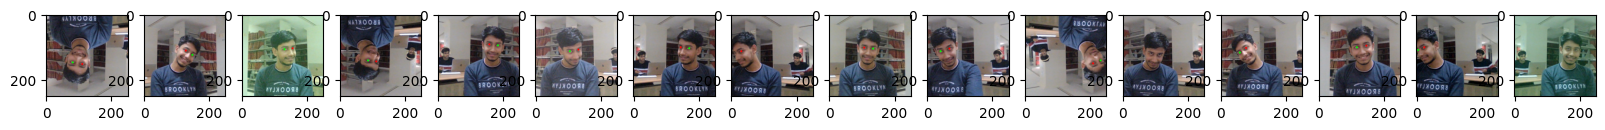

In [23]:
# Viewing samples
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols = 16, figsize = (20, 20))
for idx in range(16):
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    
    # Red circle is left eye
    # Blue circle is R eye
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 3, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 3, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [46]:
# Building the model

model = Sequential([
    Input(shape = (250, 250, 3)),
    ResNet152V2(include_top = False, input_shape = (250, 250, 3)),
    Conv2D(512, 3, padding = 'same', activation = 'relu'),
    Conv2D(512, 3, padding = 'same', activation = 'relu'),
    Conv2D(256, 3, 2, padding = 'same', activation = 'relu'),
    Conv2D(256, 2, 2, activation = 'ReLU'),
    Dropout(0.05),
    Conv2D(4,2,2),
    Reshape((4,))
])

234545216/234545216 [==============================] - 94s 0us/step


In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 4)           4

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, weight_decay = 0.0007)
loss = tf.keras.losses.MeanSquaredError()


In [57]:
model.compile(optimizer,loss)

In [58]:
X, y = train.as_numpy_iterator().next()

In [59]:
X.shape

(16, 250, 250, 3)

In [60]:
coordinates = model.predict(X)
coordinates

1/1 [==============================] - 4s 4s/step


array([[ 4.9288988e-02,  5.5960637e-01,  7.5133669e-01, -2.3907006e-02],
       [-1.6051939e+00, -3.3925486e-01,  1.0953441e+00, -3.2535595e-01],
       [-1.4381295e+00,  9.2224944e-01,  7.6909697e-01,  6.8646276e-01],
       [-1.4752135e+00,  5.0975382e-01,  5.5078828e-01, -7.1986896e-01],
       [-1.4556025e+00,  2.9987103e-01,  1.9319055e+00, -1.0962884e+00],
       [-3.5553819e-01,  2.2555590e-03,  1.7881514e+00, -6.0008359e-01],
       [-1.5428683e+00,  7.6579046e-01,  2.2749588e+00,  7.4647844e-01],
       [ 5.0421458e-01,  3.5129714e-01,  8.3427775e-01,  4.9099159e-01],
       [-6.2760025e-01, -6.7015731e-01,  1.3450174e+00, -7.0167637e-01],
       [-1.4526460e+00,  1.7320907e-01,  1.4269092e+00, -3.6994779e-01],
       [-1.5417079e+00,  1.0849135e+00,  1.0709338e+00,  5.6754053e-03],
       [-7.7464926e-01, -4.6632648e-02,  1.4225249e+00, -7.6543915e-01],
       [-5.1184750e-01, -6.6690600e-01,  2.6063366e+00, -6.1482459e-01],
       [-6.5366805e-01,  5.7490242e-01,  1.3686651e

In [61]:
# Model_training
hist = model.fit(train, epochs = 5, validation_data = val)
# Actual number of epochs is 100

Epoch 1/5
 26/315 [=>............................] - ETA: 1:03:33 - loss: 12.0325

KeyboardInterrupt: 

In [ ]:
# Reviewing the performance
hist.history
# Plotting the losses and evaluating the model
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
plt.suptitle('Loss_plot Training v/s Val')
plt.legend()
plt.show()

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = model.predict((test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
# Red circle is left eye
# Blue circle is R eye
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
ax[idx].imshow(sample_image)

In [ ]:
# Saving the model
from tensorflow.keras.models import load_model
model.save('iris_detection_model_100_epoch')
model = load_model('iris_detection_model_100_epoch')

In [ ]:
# predicting again with the same model after reloading
model.predict(test_sample[0])

In [ ]:
# Real time detection 
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()
    
    frame = frame[50:500, 50:500, :]
    rgb_img = cv2.cvtcolor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250, 250))
    
    yhat = model.predict(np.expand_dims(resized/255, 0))
    sample_coords = yhat[0,:4]
    
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('Eye_track', frame)
    
    if cv2.waitKey(1) & 0xFF = ord('q'):
        break
cap.release()
cv2.destroyAllWindows()